# Project 1: 🍔::👁 Food Image Classification
In this notebook, We're going to be building Food Image Classification model, using all of the data from the Food101 dataset.

All 75,750 training images and 25,250 testing images
## What we're going to cover

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model
* Fine-tuning the feature extraction model
* Viewing training results on TensorBoard


# Downloading Food101 dataset from Tensorflow Datasets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tdfs

To get the list of available datasets, use tfds.list_builders()

In [ ]:
# Check whether our Food101 dataset is present in TDFS or not
Datasets_list = tdfs.list_builders()

target = "food101"
print(f"The {target} dataset is present in {target in Datasets_list}")


The food101 dataset is present in True


The easiest way of loading a dataset is `tfds.load`. It will:

* Download the data and save it as tfrecord files.
* Load the tfrecord and create the tf.data.Dataset.
* split= it splits the data ["train","validation"]
* shuffle_files=: Control whether to shuffle the files between each epoch (TFDS store big datasets in multiple smaller files).
* with_info=True: Returns the tfds.core.DatasetInfo containing dataset metadata

In [ ]:
(train_data, test_data), ds_info = tdfs.load("food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.HEZ88T_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.HEZ88T_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


By using `with_info = True` returns the dataset info  

In [ ]:
# check what features does our dataset have
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features['label'].names
class_names[:20]
# class_names[82]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

# Create a preprocessing function for our data


In [ ]:
# first take one sample of our data and know its (shape,dtype)
sample_of_train_data = train_data.take(1)
sample_of_train_data

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in sample_of_train_data:
  print(f'''
  The image has shape: {image.shape},
  The image data type:{image.dtype},
  The label of an image in (tensor form):{label},
  The label of an image in (str form): {class_names[label.numpy()]}
  ''')


  The image has shape: (512, 512, 3),
  The image data type:<dtype: 'uint8'>,
  The label of an image in (tensor form):30,
  The label of an image in (str form): deviled_eggs
  


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

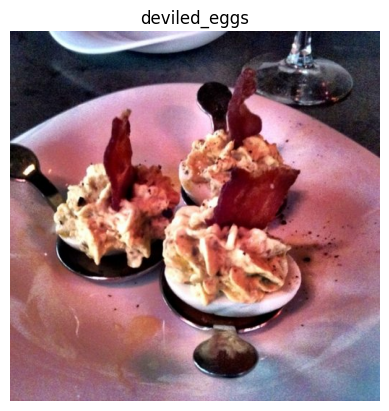

In [ ]:
# let's visualize the image
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

I created a function that helps us to make all images convert `shape into (224,224)` and `data type from unit8 to float32`

In [ ]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image, dtype=tf.float32),label

In [ ]:
preprocessed_img = preprocess_img(image,label)[0]
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 21.801022,  24.801022,  43.80102 ],
        [ 17.7551  ,  19.7551  ,  40.755104],
        [ 16.16837 ,  18.16837 ,  41.16837 ],
        ...,
        [ 37.61732 ,  46.831585,  75.964294],
        [ 30.214298,  41.2143  ,  72.02044 ],
        [ 26.163052,  36.80591 ,  69.877335]],

       [[ 22.091837,  23.091837,  43.09184 ],
        [ 10.974489,  11.974489,  31.97449 ],
        [ 16.112244,  17.112244,  38.112244],
        ...,
        [ 45.48988 ,  57.48988 ,  81.20421 ],
        [ 42.413116,  54.34169 ,  80.49475 ],
        [ 33.551304,  45.479874,  71.76559 ]],

       [[ 31.57653 ,  30.57653 ,  48.14796 ],
        [ 21.      ,  20.      ,  37.999996],
        [ 31.688778,  29.857143,  50.352043],
        ...,
        [ 36.87249 ,  52.4235  ,  70.229675],
        [ 42.530632,  57.9592  ,  76.316345],
        [ 45.449043,  60.877613,  79.23476 ]],

       ...,

       [[152.57149 ,  99.571495, 119.14297 ],
        [157.

(224, 224, 3),<dtype: 'float32'>


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

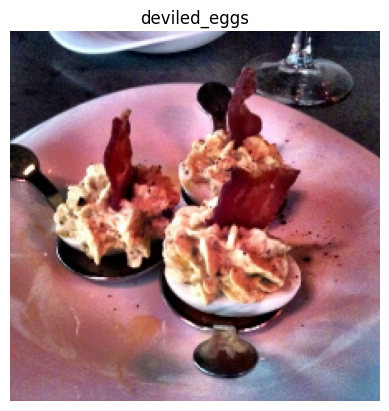

In [ ]:
print(f"{preprocessed_img.shape},{preprocessed_img.dtype}")
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label.numpy()])
plt.axis(False)


# Batching & preparing datasets for modelling (making our datasets run fast)

In this section we are going to make our images to form a batch of size 32 so that it can instead of going to run all at once it will run one batche of images at a time.

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

* By using `map()` we are going to map all images to the associated function,
* `prefetch(buffer_size=tf.data.AUTOTUNE)` is used to overlap data preprocessing and model execution during training, thereby improving performance by preventing the CPU from being idle while the GPU is busy.
 This is achieved by pre-loading the next batches of data asynchronously in the background

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Create modelling callbacks

In [ ]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
checkpoint_path = "model_checkpoint/cp.cpkt.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)


# Setting up mixed precision training

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

In [ ]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<DTypePolicy "mixed_float16">

#Build feature extraction model using EfficientNetV2B0

Callbacks: ready to roll.

Mixed precision: turned on.

Let's build a model.

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetV20).

But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model)
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

In [ ]:
# we are importing tensorflow
import tensorflow as tf

## Data Augmentation

This technique is widely used in deep learning to reduce overfitting when training

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),                     # horizontal flip
    tf.keras.layers.RandomRotation(0.20),                         # rotate up to ±20%
    tf.keras.layers.RandomTranslation(0.12, 0.12),                # translate
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),  # zoom in/out
    tf.keras.layers.RandomContrast(0.20),                         # contrast jitter
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2)
], name="heavy_augment")


## Transfer Learning model

**why EfficientNetV2BO ?**
* EfficientNetV2-B0 is commonly used for Food101 because it provides the best balance of accuracy, efficiency, and training speed for this type of image classification task.
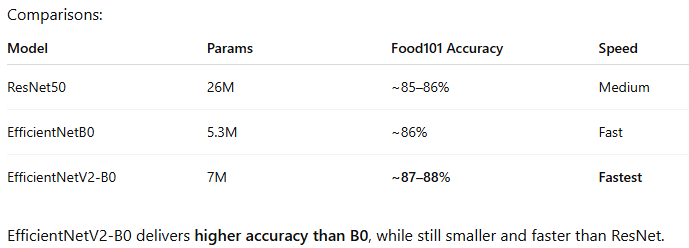


In [ ]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224,224,3), name="Input_layer")
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
x = base_model(x, training=False)
# print(f"Output shape of base_model: {x.shape}, dtype: {x.dtype}")
x = tf.keras.layers.GlobalAveragePooling2D(name="Pooling_layer")(x)
x = tf.keras.layers.BatchNormalization(name="BN_after_pool")(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ heavy_augment (Sequential)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_after_pool                   │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,053,813 (23.09 MB)

 Trainable params: 131,941 (515.39 KB)

 Non-trainable params: 5,921,872 (22.59 MB)

In [ ]:
# check which layers have what dtypes
for layer in model_1.layers:
  print(layer.name, layer.trainable, layer.dtype,layer.dtype_policy)

Input_layer True float32 <DTypePolicy "mixed_float16">
heavy_augment True float32 <DTypePolicy "mixed_float16">
efficientnetv2-b0 False float32 <DTypePolicy "mixed_float16">
Pooling_layer True float32 <DTypePolicy "mixed_float16">
BN_after_pool True float32 <DTypePolicy "mixed_float16">
dropout_1 True float32 <DTypePolicy "mixed_float16">
dense_3 True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [ ]:
len(train_data), 32 * 2368,len(test_data),790*32

(2368, 75776, 790, 25280)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # or 'val_accuracy'
    patience=8,              # stop after 5 epochs with no improvement
    verbose=1,
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # multiply LR by this factor
    patience=3,        # wait epochs before reducing
    min_lr=1e-7,
    verbose=1
)

In [ ]:
# tf.get_logger().setLevel("Error")
# Excution time : 1hr 30min
history_1 = model_1.fit(train_data,
                        epochs=15,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.15*len(test_data)),
                        callbacks=[create_tensorboard_callback("training_logs", "efficientnetb0_101_classes_all_data_feature_extract"), model_checkpoint, early_stop, reduce_lr]
                        )

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20251116-111008
Epoch 1/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 921s 377ms/step - accuracy: 0.2769 - loss: 3.3358 - val_accuracy: 0.6096 - val_loss: 1.4533 - learning_rate: 0.0010
Epoch 2/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 373s 157ms/step - accuracy: 0.4305 - loss: 2.3906 - val_accuracy: 0.6377 - val_loss: 1.3249 - learning_rate: 0.0010
Epoch 3/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 316s 129ms/step - accuracy: 0.4516 - loss: 2.2366 - val_accuracy: 0.6517 - val_loss: 1.2873 - learning_rate: 0.0010
Epoch 4/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 281s 118ms/step - accuracy: 0.4688 - loss: 2.1687 - val_accuracy: 0.6539 - val_loss: 1.2671 - learning_rate: 0.0010
Epoch 5/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 305s 111ms/step - accuracy: 0.4704 - loss: 2.1442 - val_accuracy: 0.6562 - val_loss: 1.2752 - learning_rate: 0.0010
Epoch 6/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 244s 102ms/step - accuracy: 0.4752 - loss: 2.1007 - v

In [ ]:
model_1.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.6651 - loss: 1.2193


[1.2198926210403442, 0.6667723059654236]

## Plot Loss Curve Before `fine-tuning`

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

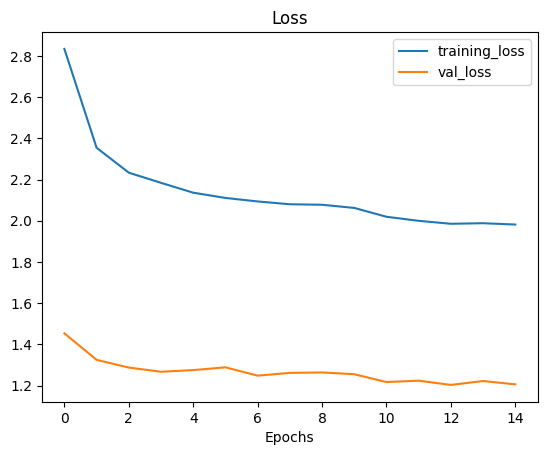

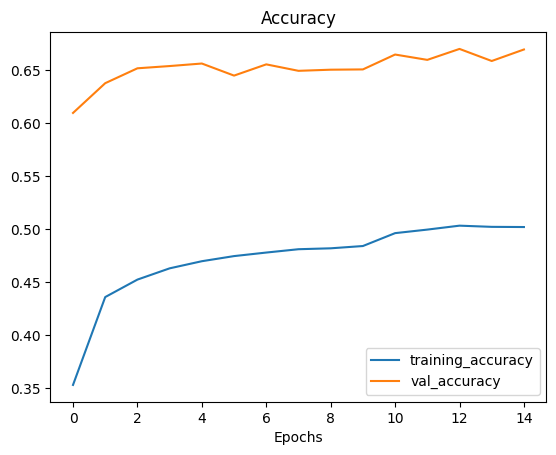

In [ ]:
plot_loss_curves(history_1)

## Selective Deep-Layer Fine-Tuning (Last 120 Layers)

In [ ]:
NUM_UNFREEZE = 120

for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= len(base_model.layers) - NUM_UNFREEZE)


In [ ]:

FINE_TUNE_LR = 1e-5         # small LR for fine-tuning
WEIGHT_DECAY = 1e-6         # small decay (if using AdamW)
opt_finetune = tf.keras.optimizers.AdamW(learning_rate=FINE_TUNE_LR, weight_decay=WEIGHT_DECAY)
model_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt_finetune, # 10x lower learning rate than default
              metrics=['accuracy'])

In [ ]:
# Fine-tune for 15 more epochs
fine_tune_epochs = 30 # model has already done 15 epochs

history_2 = model_1.fit(train_data,
                        epochs=fine_tune_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                        initial_epoch=history_1.epoch[-1],
                        callbacks=[early_stop, reduce_lr]
                        ) # start from previous last epoch

Epoch 15/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 555s 217ms/step - accuracy: 0.4126 - loss: 2.4135 - val_accuracy: 0.6753 - val_loss: 1.2279 - learning_rate: 1.0000e-05
Epoch 16/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 381s 160ms/step - accuracy: 0.5130 - loss: 1.9471 - val_accuracy: 0.6965 - val_loss: 1.1177 - learning_rate: 1.0000e-05
Epoch 17/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 383s 161ms/step - accuracy: 0.5402 - loss: 1.8170 - val_accuracy: 0.7042 - val_loss: 1.0652 - learning_rate: 1.0000e-05
Epoch 18/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 357s 150ms/step - accuracy: 0.5636 - loss: 1.7127 - val_accuracy: 0.7195 - val_loss: 1.0195 - learning_rate: 1.0000e-05
Epoch 19/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 360s 151ms/step - accuracy: 0.5759 - loss: 1.6517 - val_accuracy: 0.7267 - val_loss: 0.9754 - learning_rate: 1.0000e-05
Epoch 20/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 360s 151ms/step - accuracy: 0.5819 - loss: 1.6352 - val_accuracy: 0.7338 - val_loss: 0.9460 - learning_rate: 1.0000e-05
Epoch 21/30
2368/2368 

In [ ]:
model_1.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.7645 - loss: 0.8369


[0.837081789970398, 0.7660990357398987]

## Plot Loss curve

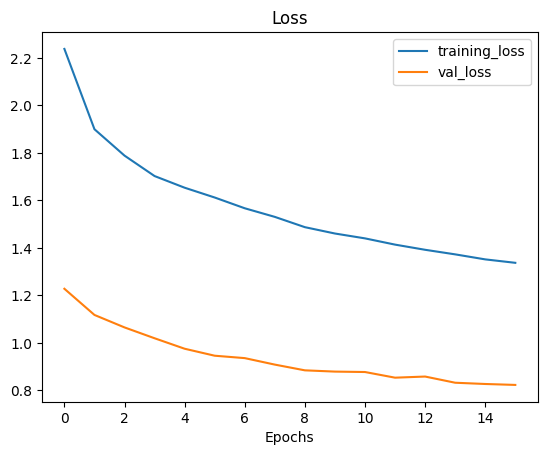

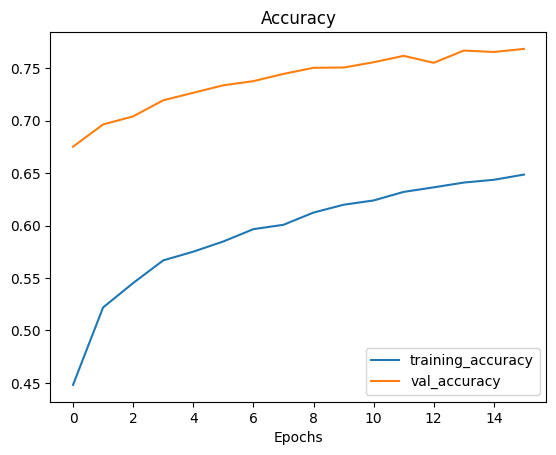

In [ ]:
plot_loss_curves(history_2)

# Comparing both accuracy and loss before and after fine tuning

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

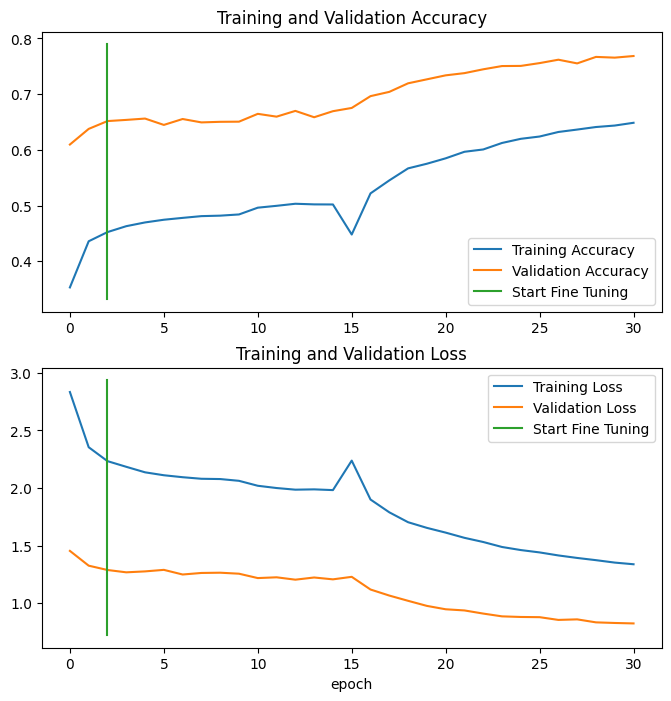

In [ ]:
compare_historys(original_history=history_1,
                 new_history=history_2,
                 initial_epochs=3)

# Prediction

In [ ]:
import numpy as np
y_true = []
y_pred = []
for batch_x, batch_y in test_data:
  preds = model_1.predict(batch_x, verbose=0)
  y_pred.extend(np.argmax(preds, axis=1))
  y_true.extend(batch_y.numpy())
y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_images(model, test_data, class_names):
  # Get one batch from test_data
  for images_batch, labels_batch in test_data.take(1):
    break # We only need the first batch

  plt.figure(figsize=(10,10))
  # Iterate over individual images in the batch
  num_images_to_plot = min(8, images_batch.shape[0]) # Plot up to 8 images, or fewer if batch size is smaller
  for i in range(num_images_to_plot):
    image = images_batch[i]
    label = labels_batch[i]

    plt.subplot(2, 4, i+1)
    # Expand dims for prediction since model expects a batch of inputs
    pred_prob = model.predict(tf.expand_dims(image, axis=0), verbose=0)
    pred_class = tf.argmax(pred_prob, axis=1)[0]
    pred_score = tf.reduce_max(pred_prob) # Corrected typo from redcue_max to reduce_max

    plt.imshow(image/255.)
    true_label = class_names[label.numpy()]
    predicted_label = class_names[pred_class.numpy()]
    color = "green" if true_label == predicted_label else "red"
    plt.title(f"True: {true_label}\nPred: {predicted_label} ({pred_score.numpy():.2f})", color=color) # .numpy() for pred_score
    plt.axis("off")
  plt.tight_layout()
  plt.show()


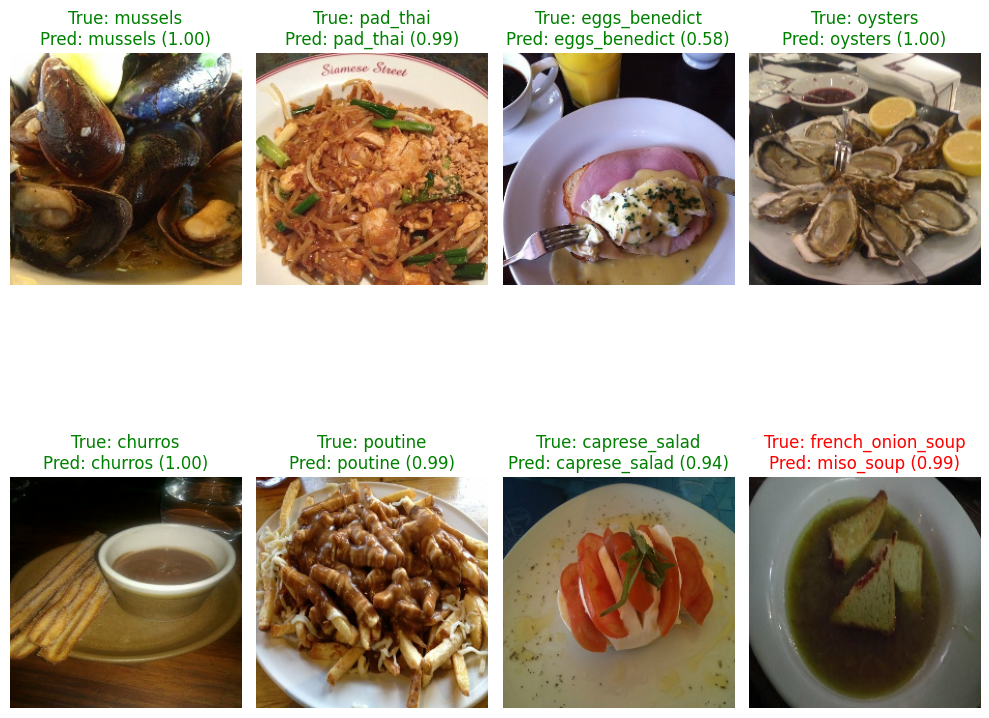

In [ ]:
plot_random_images(model_1, test_data, class_names=class_names)

# Calculating accuracy, precision, recall, f1-score

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [ ]:
calculate_results(y_true = y_true,
                  y_pred= y_pred)

{'accuracy': 76.609900990099,
 'precision': 0.7737069277036254,
 'recall': 0.7660990099009901,
 'f1': 0.7653619932424867}

# Confusion matrix

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred,
                      classes=class_names,
                      figsize=(200, 200),
                      text_size=20,
                      norm=True,
                      savefig=True)

# Saving our trained Model

In [ ]:
# # ## Saving model to Google Drive (optional)
import os
# # # Create save path to drive
save_dir = "drive/MyDrive/Projects/food_vision/"
model_name = "101_Food_classification_model.keras"
save_path = os.path.join(save_dir, model_name)

# # Create directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# # # Save model
model_1.save(save_path)

In [ ]:
import json

with open("drive/MyDrive/Projects/class_names.json", "w") as f:
    json.dump(class_names, f)


# import json

# with open("drive/MyDrive/Projects/class_names.json", "r") as f:
#     class_names = json.load(f)

# print(class_names)